<a href="https://colab.research.google.com/github/collinwa/MPCCA/blob/model_refactor/analysis_notebooks/simulate_inclusion_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np                                                                                                                                                                                                 
import pandas as pd                                                                                                                                                                                                
import torch                                                                                                                                                                                                       
import mpcca_collin.MPCCA.micca_model as micca
import mpcca_collin.MPCCA.model as model                                                                                                                                                                   
from typing import List
from scipy import stats
import seaborn as sns
torch.set_printoptions(linewidth = 200)
np.set_printoptions(linewidth = 200)

In [ ]:
import importlib
importlib.reload(micca)

<module 'mpcca_collin.MPCCA.micca_model' from '/gpfs/commons/home/bbrown/mpcca_collin/MPCCA/micca_model.py'>

In [ ]:
def generate_dataset(n, d):
  if lam is not None:
    ecdf_lam = stats.gaussian_kde(lam)
    lam_sample = torch.tensor(ecdf_lam.resample(len(lam))[0], dtype=torch.float)
    if(n > d):
      # TODO(brielin): can I just use the right SVs as V or are these not independent enough?
      U = torch.linalg.svd(torch.randn(n, d), full_matrices=False).U
      VT = torch.linalg.svd(torch.randn(d, d), full_matrices=False).Vh
    else:
      U = torch.linalg.svd(torch.randn(n, n), full_matrices=False).U
      VT = torch.linalg.svd(torch.randn(n, d), full_matrices=False).Vh
    X = U * lam_sample @ VT
  else:
    X = torch.randn(n, d)
  return X

def simulate_micca(n: int, d: List[int], k: List[int], p: int = 1, n_samples = 100):                                                                                                                                             
    """Calculates the MCCA (Parra) solution to random data.                                                                                                                                                        
                                                                                                                                                                                                                   
    Args:                                                                                                                                                                                                          
        n: Integer. Sample size.                                                                                                                                                                                   
        d: List of integers. Dimensions of the datasets to simulate.                                                                                                                                               
        p: Integer. Number of shared components to remove before residual PCA.
        lambda: List of torch tensors of length d. These are used to construct
            simulated random matrix spectra.                                                                                                                                     
    """                                                                                                                                                                                                            
    sim_res = np.empty((n_samples, 1 + len(d)))
    for sample in range(n_samples):                                                                                                                                                                                
        datasets = [torch.randn(n, di) for di in d]                                                                                                                                               
        micca_res = micca.micca(datasets, c_shared=p, c_private=[1]*len(d), dimensions=k)                                                                                                                                        
        iter_data = np.array([micca_res.rho.numpy()[0]] +                                                                                                                                                          
                       [lam.numpy()[0] for lam in micca_res.lam_private])                                                                                                                                          
        sim_res[sample, :] = iter_data                                                                                                                                                                                
    sim_res = pd.DataFrame(                                                                                                                                                                                        
        sim_res, columns = ['rho'] + ['lam'+str(i) for i in range(len(d))])                                                                                                                                        
    return sim_res

def simulate_em_latent(n: int, d: List[int], p: int = 1, n_samples = 100):                                                                                                                                             
    """Calculates the MPCCA (EM) solution to random data.                                                                                                                                                        
                                                                                                                                                                                                                   
    Args:                                                                                                                                                                                                          
        n: Integer. Sample size.                                                                                                                                                                                   
        d: List of integers. Dimensions of the datasets to simulate.                                                                                                                                               
        p: Integer. Number of shared components to remove before residual PCA.                                                                                                                                     
    """                                                                                                                                                                                                            
    sim_res = np.empty((n_samples, p))                                                                                                                                                                   
    for sample in range(n_samples):                                                                                                                                                                                
        datasets = [torch.tensor(np.random.normal(                                                                                                                                                                 
            loc=0, scale=1, size=n*di).reshape((n,di))) for di in d]
        y_concat = torch.cat(datasets, axis=1).double()
        y_dims = torch.tensor(d)
        x_dims = torch.tensor([2]*len(d))                                                                                                  
        W_model, L_model, Phi_model = model.fit_model(y_dims, x_dims, datasets, p, y_concat, n, steps=500, toprint=100, method="stable")
        gen_vars, _ = micca.calc_feature_genvar(W_model.T, Phi_model)
        print(min(gen_vars))
        latent_data_list = [model.project_latent_individual(W_model, L_model, Phi_model, p, y_concat, x_dims, y_dims, i)[0] for i in range(len(d))]
        rho, rb, rw = model.compute_ISC(latent_data_list)
        print(max(rho))
        iter_data = rho.numpy()                                                                                                                                        
        sim_res[sample] = iter_data                                                                                                                                                                                
    sim_res = pd.DataFrame(sim_res, columns=["rho_" + str(i) for i in range(p)])
    return sim_res

def simulate_em_simple(n: int, d: List[int], p: int = 1, n_samples = 100):                                                                                                                                             
    """Calculates the MPCCA (EM) solution to random data.                                                                                                                                                        
                                                                                                                                                                                                                   
    Args:                                                                                                                                                                                                          
        n: Integer. Sample size.                                                                                                                                                                                   
        d: List of integers. Dimensions of the datasets to simulate.                                                                                                                                               
        p: Integer. Number of shared components to remove before residual PCA.                                                                                                                                     
    """                                                                                                                                                                                                            
    sim_res = np.empty((n_samples, p))                                                                                                                                                                   
    for sample in range(n_samples):                                                                                                                                                                                
        datasets = [torch.tensor(np.random.normal(                                                                                                                                                                 
            loc=0, scale=1, size=n*di).reshape((n,di))) for di in d]                                                                                                                                           
        W_model, Phi_model = micca.fit_EM(datasets, d=p, niter=500)
        gen_vars, total = micca.calc_feature_genvar(W_model, Phi_model)
        print(gen_vars)
        print(total)
        iter_data = gen_vars.numpy()                                                                                                                                        
        sim_res[sample] = iter_data                                                                                                                                                                                
    sim_res = pd.DataFrame(sim_res, columns=["gen_var_" + str(i) for i in range(p)])
    return sim_res


In [ ]:
n_samples = 1000
n = 685
d = [11, 33, 49, 66, 29] # [11, 20212, 136545, 6042, 1252]
k = [11, 33, 49, 66, 29]
sim_res = simulate_micca(n=685, d=d, p=15, k=k, n_samples=n_samples)
print(sim_res)
print(sim_res.mean())
print(np.sqrt(sim_res.var()/n_samples))

          rho          lam0      lam1      lam2      lam3      lam4
0    0.258698  1.035330e-15  1.139778  1.191013  1.258509  1.108794
1    0.256040  1.322059e-15  1.136828  1.214310  1.247792  1.135921
2    0.264354  1.432440e-15  1.117148  1.242487  1.295516  1.179863
3    0.260046  1.415792e-15  1.124557  1.206862  1.250550  1.141029
4    0.251159  1.454914e-15  1.115594  1.207076  1.231101  1.138084
..        ...           ...       ...       ...       ...       ...
995  0.253543  1.471786e-15  1.149174  1.196339  1.262490  1.114686
996  0.253748  1.433331e-15  1.135883  1.182950  1.251257  1.095737
997  0.253144  9.439523e-16  1.133157  1.191262  1.239744  1.108834
998  0.271002  1.144244e-15  1.135903  1.196102  1.237651  1.124490
999  0.262126  1.390974e-15  1.133492  1.188132  1.294842  1.104374

[1000 rows x 6 columns]
rho     2.534394e-01
lam0    1.657319e-15
lam1    1.139830e+00
lam2    1.202078e+00
lam3    1.253496e+00
lam4    1.119363e+00
dtype: float64
rho     1.821399e-

<AxesSubplot:xlabel='rho', ylabel='Count'>

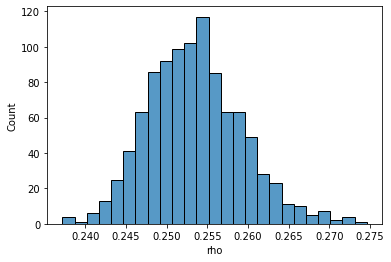

In [ ]:
sns.histplot(data = sim_res, x = 'rho')

In [ ]:
n_samples = 1000
n = 685
d = [33, 49, 66, 29] # [11, 20212, 136545, 6042, 1252]
k = [33, 49, 66, 29]
sim_res = simulate_micca(n=685, d=d, p=15, k=k, n_samples=n_samples)
print(sim_res)
print(sim_res.mean())
print(np.sqrt(sim_res.var()/n_samples))

          rho      lam0      lam1      lam2      lam3
0    0.310419  1.150183  1.198657  1.257408  1.099657
1    0.319387  1.125765  1.198075  1.263977  1.109190
2    0.311540  1.152199  1.197347  1.242903  1.152226
3    0.335476  1.133785  1.194594  1.255491  1.105391
4    0.311475  1.156464  1.205699  1.251980  1.117362
..        ...       ...       ...       ...       ...
995  0.323583  1.127913  1.186675  1.241113  1.124534
996  0.325488  1.133397  1.211668  1.252847  1.118864
997  0.314595  1.168250  1.203992  1.246749  1.155023
998  0.317887  1.135206  1.183842  1.249520  1.132108
999  0.317812  1.144345  1.201510  1.243219  1.127537

[1000 rows x 5 columns]
rho     0.314524
lam0    1.140279
lam1    1.202684
lam2    1.253499
lam3    1.119633
dtype: float64
rho     0.000224
lam0    0.000460
lam1    0.000401
lam2    0.000397
lam3    0.000472
dtype: float64


<AxesSubplot:xlabel='rho', ylabel='Count'>

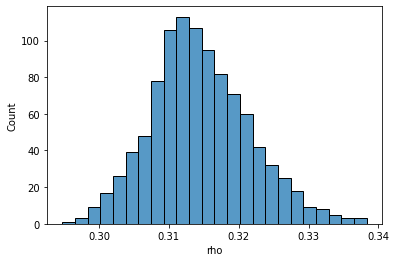

In [ ]:
sns.histplot(data = sim_res, x = 'rho')

In [ ]:
# New with less samples!
n_samples = 1000
n = 614
d = [11, 30, 37, 63, 27] # [11, 20212, 136545, 6042, 1252]
k = [11, 30, 37, 63, 27]
sim_res = simulate_micca(n=685, d=d, p=15, k=k, n_samples=n_samples)
print(sim_res)
print(sim_res.mean())
print(np.sqrt(sim_res.var()/n_samples))

          rho          lam0      lam1      lam2      lam3      lam4
0    0.243267  1.977240e-15  1.126108  1.168824  1.248423  1.114061
1    0.245725  1.274841e-15  1.120201  1.153263  1.245933  1.101264
2    0.247398  1.512380e-15  1.135160  1.152660  1.223348  1.119719
3    0.240577  1.095152e-15  1.142939  1.171638  1.248281  1.092001
4    0.246169  8.994811e-16  1.132303  1.165510  1.240342  1.105413
..        ...           ...       ...       ...       ...       ...
995  0.236015  9.861054e-16  1.095094  1.139718  1.226217  1.095792
996  0.230564  6.184222e-15  1.121144  1.152957  1.252773  1.103905
997  0.246119  1.519372e-15  1.155304  1.158981  1.248616  1.100601
998  0.234147  1.049694e-15  1.114917  1.161805  1.233099  1.095462
999  0.236737  1.504411e-15  1.128424  1.157019  1.244097  1.123560

[1000 rows x 6 columns]
rho     2.381290e-01
lam0    1.612051e-15
lam1    1.124981e+00
lam2    1.157958e+00
lam3    1.244977e+00
lam4    1.108539e+00
dtype: float64
rho     1.825724e-

In [ ]:
# New with less samples!
# Exam 1
n_samples = 1000
n = 614
d = [30, 37, 63, 27] # [11, 20212, 136545, 6042, 1252]
k = [30, 37, 63, 27]
sim_res = simulate_micca(n=n, d=d, p=15, k=k, n_samples=n_samples)
print(sim_res)
print(sim_res.mean())
print(np.sqrt(sim_res.var()/n_samples))

          rho      lam0      lam1      lam2      lam3
0    0.320578  1.130657  1.177922  1.240827  1.100804
1    0.317757  1.131723  1.180814  1.259849  1.114117
2    0.314573  1.133803  1.144913  1.270716  1.129283
3    0.307691  1.109894  1.179461  1.241772  1.106463
4    0.299075  1.142428  1.163395  1.265644  1.090644
..        ...       ...       ...       ...       ...
995  0.312658  1.132536  1.159907  1.239110  1.120385
996  0.321436  1.127724  1.186606  1.244745  1.133853
997  0.311329  1.131078  1.175646  1.254509  1.105949
998  0.313112  1.136964  1.143419  1.245005  1.108425
999  0.304826  1.134786  1.181821  1.243726  1.142509

[1000 rows x 5 columns]
rho     0.311571
lam0    1.131281
lam1    1.165546
lam2    1.259031
lam3    1.114528
dtype: float64
rho     0.000238
lam0    0.000481
lam1    0.000461
lam2    0.000439
lam3    0.000501
dtype: float64


In [ ]:
# New with less samples!
# Exam 5
n_samples = 1000
n = 652
d = [33, 35, 65, 24] # [11, 20212, 136545, 6042, 1252]
k = [33, 35, 65, 24]
sim_res = simulate_micca(n=n, d=d, p=15, k=k, n_samples=n_samples)
print(sim_res)
print(sim_res.mean())
print(np.sqrt(sim_res.var()/n_samples))

          rho      lam0      lam1      lam2      lam3
0    0.298904  1.137406  1.117267  1.274493  1.105144
1    0.297770  1.155581  1.144521  1.234707  1.103742
2    0.296310  1.132263  1.160156  1.246977  1.083557
3    0.295986  1.150054  1.148310  1.268373  1.102212
4    0.291613  1.126885  1.176688  1.250780  1.102819
..        ...       ...       ...       ...       ...
995  0.293826  1.149765  1.138378  1.265901  1.104733
996  0.295106  1.147655  1.143307  1.242170  1.125958
997  0.289640  1.176098  1.173583  1.270809  1.087282
998  0.294295  1.139120  1.141223  1.242228  1.080656
999  0.298060  1.151335  1.149921  1.243482  1.092042

[1000 rows x 5 columns]
rho     0.300501
lam0    1.142927
lam1    1.152455
lam2    1.257498
lam3    1.092104
dtype: float64
rho     0.000238
lam0    0.000456
lam1    0.000456
lam2    0.000407
lam3    0.000508
dtype: float64


In [ ]:
d=[11, 33, 49, 66, 29]
n=685
datasets = [torch.tensor(np.random.normal(loc=0, scale=1, size=n*di).reshape((n,di))) for di in d]
micca.pca(datasets[0]).lam

tensor([1.1180, 1.0767, 1.0380, 1.0327, 1.0169, 1.0079, 0.9731, 0.9564, 0.9440, 0.9255, 0.8876], dtype=torch.float64)

In [ ]:
n = 685
d = 10000
X = torch.tensor(np.random.normal(loc=0, scale=1, size=n*d).reshape((n, d)))
Ux, Sx, VxT = torch.linalg.svd(X)
Y = (X @ X.T)/n
Uy, Sy, _ = torch.linalg.svd(Y)
print(1 + np.sqrt(d / n))

4.82080359950435


In [ ]:
Sx**2/n

tensor([23.1014, 22.9944, 22.9480, 22.8604, 22.7819, 22.6875, 22.5659, 22.4613, 22.4232, 22.3789, 22.3145, 22.2555, 22.2165, 22.1716, 22.1452, 22.0848, 21.9862, 21.9448, 21.9153, 21.8772, 21.8629,
        21.8335, 21.7476, 21.7210, 21.6920, 21.6258, 21.5932, 21.5451, 21.5103, 21.4658, 21.4472, 21.4007, 21.3470, 21.3414, 21.2995, 21.2793, 21.2356, 21.1819, 21.1731, 21.1271, 21.0862, 21.0436,
        21.0244, 21.0203, 20.9288, 20.9166, 20.8930, 20.8795, 20.8080, 20.7961, 20.7636, 20.6837, 20.6616, 20.6151, 20.5769, 20.5731, 20.5140, 20.4938, 20.4605, 20.4276, 20.4025, 20.3729, 20.3349,
        20.3232, 20.2903, 20.2458, 20.2079, 20.1697, 20.1643, 20.1269, 20.0989, 20.0729, 20.0327, 20.0298, 19.9921, 19.9657, 19.9461, 19.8844, 19.8769, 19.8670, 19.8478, 19.7994, 19.7700, 19.7489,
        19.7204, 19.6967, 19.6754, 19.6086, 19.5939, 19.5796, 19.5332, 19.5253, 19.4732, 19.4507, 19.4420, 19.3882, 19.3799, 19.3575, 19.3064, 19.2603, 19.2565, 19.2323, 19.2260, 19.1518, 19.1501,
        19.1046

tensor([0.9998, 0.9903, 1.0008, 1.0003, 1.0009, 1.0005, 1.0010, 1.0007, 1.0014, 0.9956, 1.0010, 0.9982, 1.0015, 0.9964, 0.9987, 1.0014, 0.9978, 1.0014, 1.0012, 1.0014, 1.0012, 1.0014, 1.0000, 1.0014,
        1.0014, 1.0014, 1.0015, 0.9987, 0.9989, 1.0012, 0.9976, 1.0014, 0.9985, 0.9947, 1.0010, 0.9990, 0.9971, 0.9979, 0.9993, 1.0002, 1.0012, 1.0012, 1.0014, 1.0003, 1.0015, 1.0013, 1.0011, 1.0012,
        0.9968, 1.0014, 0.9969, 0.9997, 1.0014, 0.9999, 1.0002, 0.9945, 1.0010, 1.0002, 1.0007, 1.0006, 1.0006, 1.0007, 0.9966, 0.9991, 0.9993, 1.0014, 1.0009, 0.9998, 0.9994, 0.9979, 1.0014, 0.9993,
        0.9930, 1.0013, 1.0014, 1.0013, 1.0014, 0.9975, 1.0003, 0.9996, 1.0013, 1.0011, 1.0010, 0.9994, 1.0014, 1.0010, 1.0006, 0.9985, 0.9990, 1.0014, 1.0000, 0.9978, 0.9998, 1.0001, 1.0014, 1.0012,
        0.9998, 1.0009, 1.0009, 1.0013, 1.0013, 0.9990, 1.0014, 1.0010, 1.0003, 1.0015, 0.9998, 1.0014, 1.0010, 1.0004, 1.0011, 1.0011, 1.0009, 0.9981, 1.0013, 1.0004, 0.9978, 1.0006, 1.0015, 1.0010,


In [ ]:
(A.T @ A).shape

torch.Size([3, 3])

In [ ]:
A = V_splits[0]
print( A @ torch.linalg.lstsq(A.T @ A, A.T)[0] )
print( A @ torch.linalg.inv(A.T @ A) @ A.T)

tensor([[ 0.5646,  0.2357, -0.2792, -0.0367,  0.0826, -0.0040,  0.0131,  0.2886,  0.0513,  0.1345],
        [ 0.2357,  0.1619, -0.1894, -0.1263, -0.0884,  0.0072,  0.0829, -0.0060, -0.0126,  0.1157],
        [-0.2792, -0.1894,  0.4480,  0.0654,  0.2382, -0.1482,  0.0965,  0.0093,  0.1466,  0.1399],
        [-0.0367, -0.1263,  0.0654,  0.2247,  0.1604,  0.0342, -0.2040,  0.1998,  0.0089, -0.2100],
        [ 0.0826, -0.0884,  0.2382,  0.1604,  0.3339, -0.1032, -0.0307,  0.2910,  0.1543,  0.0722],
        [-0.0040,  0.0072, -0.1482,  0.0342, -0.1032,  0.0878, -0.1079, -0.0240, -0.0874, -0.1625],
        [ 0.0131,  0.0829,  0.0965, -0.2040, -0.0307, -0.1079,  0.2573, -0.1416,  0.0726,  0.3086],
        [ 0.2886, -0.0060,  0.0093,  0.1998,  0.2910, -0.0240, -0.1416,  0.3995,  0.0979, -0.0414],
        [ 0.0513, -0.0126,  0.1466,  0.0089,  0.1543, -0.0874,  0.0726,  0.0979,  0.1010,  0.1419],
        [ 0.1345,  0.1157,  0.1399, -0.2100,  0.0722, -0.1625,  0.3086, -0.0414,  0.1419,  0.4213]],

In [ ]:
# testing private

def make_P_mats(A_list):
  P_pars = [A @ torch.linalg.lstsq(A.T @ A, A.T)[0] for A in A_list]
  P_perps = [torch.eye(P.shape[0]) - P for P in P_pars]
  return P_pars, P_perps

n = 1000
d = [10, 20, 30]
dimensions = [10, 20, 30]
c_shared = 3
n_sets = len(d)
datasets = [torch.tensor(np.random.normal(loc=0, scale=1, size=n*di).reshape((n, di))) for di in d]
data_pcs = [micca.pca(ds) for ds in datasets]
U_splits = [data_pc.U[:, 0:k] for data_pc, k in zip(data_pcs, dimensions)]
U_all = torch.cat(U_splits, dim=1)
M = U_all.T @ U_all
values, vectors = torch.linalg.eigh(M)
values = torch.flip(values, dims=[0])
vectors = torch.flip(vectors, dims=[1])
rho = (values[0:c_shared] - 1)/(n_sets - 1)
V = np.sqrt(n_sets) * vectors[:, 0:c_shared]
dimsum = np.concatenate([[0], np.cumsum(dimensions, 0)])
V_splits = [V[i:j, :] for i, j in zip(dimsum[:-1], dimsum[1:])]
P_pars, P_perps = make_P_mats(V_splits)

In [ ]:
X0 = datasets[0]
P0_par = P_pars[0]
P0_perp = P_perps[0]
U0, l0, V0T = torch.linalg.svd(X0, full_matrices=False)
X0_par = U0 @ P0_par * l0 @ V0T
X0_perp = U0 @ P0_perp * l0 @ V0T

print(torch.linalg.svd(X0_perp).S[0:3])
print(torch.linalg.svd(X0_perp).U[:, 0:3])

tensor([33.9038, 33.1173, 32.1625], dtype=torch.float64)
tensor([[-0.0288, -0.0631,  0.0124],
        [ 0.0073, -0.0105,  0.0092],
        [ 0.0254,  0.0054, -0.0451],
        ...,
        [ 0.0029,  0.0145, -0.0292],
        [ 0.0131,  0.0160, -0.0085],
        [ 0.0385,  0.0132,  0.0306]], dtype=torch.float64)


In [ ]:
U0_perp = torch.linalg.svd(P0_perp).U
idk = U0 @ P0_perp * l0
l0perp = torch.linalg.svd(idk).S
print(torch.linalg.svd(idk).S[0:3])  # EVs of resid mat. EVs of resid cov are this**2/n
print(torch.linalg.svd(idk).U[:, 0:3])  # Left SVs of resid mat

tensor([33.9038, 33.1173, 32.1625], dtype=torch.float64)
tensor([[-0.0288, -0.0631, -0.0124],
        [ 0.0073, -0.0105, -0.0092],
        [ 0.0254,  0.0054,  0.0451],
        ...,
        [ 0.0029,  0.0145,  0.0292],
        [ 0.0131,  0.0160,  0.0085],
        [ 0.0385,  0.0132, -0.0306]], dtype=torch.float64)


In [ ]:
n = 1000
d = 100
sigma = np.sqrt(np.random.normal(1, 1, size = d)**2)
print(min(sigma**2), max(sigma**2), np.mean(sigma**2), np.median(sigma**2))

Y = np.random.normal(scale = sigma, size = (n,d))
Y = Y - np.mean(Y, 0)

C = Y.T @ Y / n

np.linalg.svd(C)[1][0]

8.105698520320091e-05 13.55598235909839 1.9348721759263083 1.2117210419185407


14.181129383287796

In [ ]:
np.max(sigma**2)*(1 + np.sqrt(d/n))**2

23.485136630170928

In [ ]:
np.linalg.svd(np.diag(sigma**2))[1]

array([1.35559824e+01, 9.38379972e+00, 7.52784029e+00, 7.37787979e+00, 6.91764503e+00, 6.11886543e+00, 5.67558693e+00, 5.40229265e+00, 5.00933889e+00, 4.83701856e+00, 4.78366940e+00, 4.27342312e+00,
       4.14347345e+00, 4.05536746e+00, 4.00851988e+00, 3.99264250e+00, 3.93960886e+00, 3.90045029e+00, 3.89416360e+00, 3.84939090e+00, 3.01619510e+00, 3.00857187e+00, 2.71967729e+00, 2.57733871e+00,
       2.57598602e+00, 2.51706790e+00, 2.47780558e+00, 2.38936363e+00, 2.09716754e+00, 2.08983359e+00, 1.96895257e+00, 1.96836496e+00, 1.94523424e+00, 1.90472145e+00, 1.86342522e+00, 1.83026886e+00,
       1.65594659e+00, 1.54901228e+00, 1.54812609e+00, 1.53865815e+00, 1.49557017e+00, 1.49437897e+00, 1.45611896e+00, 1.42534034e+00, 1.37257308e+00, 1.34763312e+00, 1.23864946e+00, 1.21938282e+00,
       1.21897592e+00, 1.21572061e+00, 1.20772148e+00, 1.18979589e+00, 1.10386189e+00, 1.09743010e+00, 1.07302856e+00, 1.06506790e+00, 1.03161531e+00, 1.01993493e+00, 9.97146691e-01, 8.96470121e-01,
     

13.909968281510594